# __Papers:__
> Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> Biological pattern formation: fmm basic mechanisms ta complex structures

> [Link](https://doi.org/10.1103/RevModPhys.66.1481)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The main PDE that the training dataset is created is as follow:

<h3><center>$\partial_t a = D_a (\partial_x^2 + \partial_y^2)a + \rho_a \frac{a^2 s}{1 + \kappa_a a^2} - \mu_a a + \sigma_a$</center></h3>

<h3><center>$\partial_t s = D_s (\partial_x^2 + \partial_y^2)s - \rho_s \frac{a^2 s}{1 + \kappa_a a^2} + \sigma_s$</center></h3>

With parameters  :
- $D_a = 0.005, \quad D_s=0.2$.
- $\mu_a = 0.01$.
- $\sigma_a = 0.0, \quad \sigma_s=0.02$.
- $\rho_a=0.01, \quad \rho_s = 0.02, \quad \kappa_a=0.25$

Using the following transformations
- <h3>$\tilde{x} =  \frac{x}{\sqrt{D_s}} , \qquad \tilde{y} =  \frac{y}{\sqrt{D_s}}$.</h3>
- <h3>$\gamma =  \frac{D_s}{D_a}$.</h3>
- <h3>$\tilde{\mu}_a =  \gamma \mu_a, \qquad \tilde{\rho_a} = \gamma \rho_a, \qquad \tilde{\sigma}_a = \gamma \sigma_a$.</h3>

**and the dimensionless equation obtains as**

<h3><center>$ \gamma \partial_t a = (\partial_\tilde{x}^2 + \partial_\tilde{y}^2)a + \tilde{\rho}_a\frac{a^2 s}{1 + \kappa_a a^2} - \tilde{\mu}_a a + \tilde{\sigma}_a$</center></h3>

<h3><center>$\partial_t s =  (\partial_\tilde{x}^2 + \partial_\tilde{y}^2)s - \rho_s \frac{a^2 s}{1 +\kappa_a a^2} + \sigma_s$</center></h3>

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            #self.D_a = tf.Variable([1.0], dtype=tf.float32, 
            #                       name="D_a", 
            #                       constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.005, dtype=tf.float32, name="D_a")#
            self.D_s = tf.constant(0.2, dtype=tf.float32, name="D_s")#tf.Variable([1.0], dtype=tf.float32, 
                                   #name="D_s",
                                  #constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))
                                                                                   
            #self.gamma = tf.math.divide(self.D_s, self.D_a, name="gamma")
            self.gamma = tf.Variable([1.0], dtype=tf.float32, 
                                   name="gamma", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))
                                                                                   
            self.sigma_a_tilde = tf.Variable([0.0], dtype=tf.float32,
                                      name="sigma_a_tilde",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10)
                                      )#tf.constant(0.0, dtype=tf.float32, name="sigma_a")#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a_tilde = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a_tilde",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a_tilde = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a_tilde",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                    name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32, name="rho_s")#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float32)#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")                
                
        self.lb_tilde, self.ub_tilde =  self.net_lb_ub_transform(self.lb, self.ub)
        self.x_tilde, self.y_tilde = self.net_xy_transform(self.x_tf, self.y_tf)
        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tilde, self.y_tilde, self.t_tf)
        

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
        

        self.loss = self.loss_1 + self.loss_a + self.loss_s 

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        #H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        H = 2.0*(X - self.lb_tilde)/(self.ub_tilde - self.lb_tilde) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def _xy_transform(self, val_tensor):
        """x or y to x_tilde, y_tilde"""
        return val_tensor/tf.math.sqrt(self.D_s)        
    
                                                                                   
    def net_xy_transform(self, x, y):
        """x and y to x_tilde, y_tilde"""
        x_tilde = self._xy_transform(x)
        y_tilde = self._xy_transform(y)
        
        return (x_tilde, y_tilde)
    
    def net_lb_ub_transform(self, lb, ub):        
        
        lb_tilde = tf.Variable([self._xy_transform(lb[0]),
                             self._xy_transform(lb[1]),
                             lb[2]])
        
        ub_tilde = tf.Variable([self._xy_transform(ub[0]),
                             self._xy_transform(ub[1]),
                             ub[2]])          
        
        return (lb_tilde, ub_tilde)
            
    def net_ASDM(self, x, y, t):        
        sigma_a_tilde = self.sigma_a_tilde
        mu_a_tilde = self.mu_a_tilde
        rho_a_tilde = self.rho_a_tilde
        kappa_a = self.kappa_a
                                                                                   
        rho_s = self.rho_s
        sigma_s = self.sigma_s
                                                                                   
        gamma = self.gamma
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        
        
        a_t = tf.gradients(a, t)[0]
        a_t_temp = tf.identity(a_t, name="temp_a_t")
        
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        a_diff_temp = tf.identity(a_xx + a_yy, name="temp_a_diff")
        
        s_t = tf.gradients(s, t, name="s_t")[0]
        s_t_temp = tf.identity(s_t, name="temp_s_t")
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        s_diff_temp = tf.identity(s_xx + s_yy, name="temp_s_diff")
        
        f = a*a*s/(1 + kappa_a*a*a)
        kin_temp = tf.identity(f, name="temp_kin")
        f_a = gamma*a_t - (a_xx + a_yy) - rho_a_tilde*f + mu_a_tilde*a - sigma_a_tilde
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s   
        
        
        return a, s, f_a, f_s 
    
    def callback(self, loss, loss_a, loss_s, D_s,gamma, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_s: {D_s.tolist()}, gamma: {gamma.tolist()}\n"
              f"sigma_a_tilde: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a_tilde: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a_tilde: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train(self, nIter, early_stop_thresh = None, print_iter = 100): 
        
        

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                #D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                gamma_value = self.sess.run(self.gamma)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]                
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a_tilde)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_s: {D_s_value.tolist()}, gamma:{gamma_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a_tilde: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)                
                #D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                gamma_value = self.sess.run(self.gamma)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]                
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a_tilde)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_s: {D_s_value.tolist()}, gamma:{gamma_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a_tilde: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100):
        
        data_n = self.x.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        data = np.concatenate([self.x, self.y, self.t, self.a, self.s], 1)
        indices = np.array(list(range(data_n)))
        
        arr_total_loss = np.zeros(nIter)
        arr_total_loss_a = np.zeros(nIter)
        arr_total_loss_s = np.zeros(nIter)
        
        #arr_D_a = np.zeros(nIter)
        arr_D_s = np.zeros(nIter)
        arr_gamma = np.zeros(nIter)
        arr_sigma_a = np.zeros(nIter)
        arr_sigma_s = np.zeros(nIter)
        arr_rho_a = np.zeros(nIter)
        arr_rho_s = np.zeros(nIter)
        arr_mu_a = np.zeros(nIter)
        arr_kappa_a = np.zeros(nIter)
        
        def _get_val(item):
            val = item.tolist()
            if type(val) is float:
                return val
            else:
                return val[0]
        

        
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices)                        
            total_loss = 0
            total_loss_a = 0
            total_loss_s = 0
            
            for batch in range(batch_steps):
                start = batch*batch_size
                end = (batch+1)*batch_size
                end = end - (end//data_n)*(end%data_n)
                
                batch_indices = indices[start:end]
                
                tf_dict = {self.x_tf: data[batch_indices, 0:1], 
                           self.y_tf: data[batch_indices, 1:2], 
                           self.t_tf: data[batch_indices, 2:3],
                           self.a_tf: data[batch_indices, 3:4], 
                           self.s_tf: data[batch_indices, 4:5]}
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                
                total_loss += loss_value
                total_loss_a += loss_a_value
                total_loss_s += loss_s_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                #D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                gamma_value = self.sess.run(self.gamma)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]                
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a_tilde)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss:.2f},\n"
                      f"D_s: {D_s_value.tolist()}, gamma:{gamma_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a_tilde: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
            # early stop
            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                #D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                gamma_value = self.sess.run(self.gamma)#[0]
                sigma_a_value = self.sess.run(self.sigma_a_tilde)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]                
                rho_a_value = self.sess.run(self.rho_a_tilde)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a_tilde)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss:.2f},\n"
                      f"D_s: {D_s_value.tolist()}, gamma:{gamma_value.tolist()}\n"
                      f"sigma_a_tilde: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a_tilde: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a_tilde: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
                arr_total_loss[it] = total_loss
                arr_total_loss_a[it] = total_loss_a
                arr_total_loss_s[it] = total_loss_s
                arr_total_loss[it] = total_loss
                arr_total_loss_a[it] = total_loss_a
                arr_total_loss_s[it] = total_loss_s
                #arr_D_a[it] = _get_val(D_a_value)
                arr_D_s[it] = _get_val(D_s_value)
                arr_gamma[it] = _get_val(gamma_value)
                arr_sigma_a[it] = _get_val(sigma_a_value)
                arr_sigma_s[it] = _get_val(sigma_s_value)
                arr_rho_a[it] = _get_val(rho_a_value)
                arr_rho_s[it] = _get_val(rho_s_value)
                arr_mu_a[it] = _get_val(mu_a_value)
                arr_kappa_a[it] = _get_val(kappa_a_value)
                                
                params = {'D_s': arr_D_s[:(it+1)], 'gamma': arr_gamma[:(it+1)], 
                          'sigma_a': arr_sigma_a[:(it+1)] , 'sigma_s': arr_sigma_s[:(it+1)],
                          'rho_a' : arr_rho_a[:(it+1)], 'rho_s' : arr_rho_s[:(it+1)],
                          'mu_a': arr_mu_a[:(it+1)], 'kappa_a': arr_kappa_a[:(it+1)]}
                
                return (arr_total_loss[:(it+1)], arr_total_loss_a[:(it+1)], arr_total_loss_s[:(it+1)], params)    
        
            arr_total_loss[it] = total_loss
            arr_total_loss_a[it] = total_loss_a
            arr_total_loss_s[it] = total_loss_s
            #arr_D_a[it] = _get_val(D_a_value)
            arr_D_s[it] = _get_val(D_s_value)
            arr_gamma[it] = _get_val(gamma_value)
            arr_sigma_a[it] = _get_val(sigma_a_value)
            arr_sigma_s[it] = _get_val(sigma_s_value)
            arr_rho_a[it] = _get_val(rho_a_value)
            arr_rho_s[it] = _get_val(rho_s_value)
            arr_mu_a[it] = _get_val(mu_a_value)
            arr_kappa_a[it] = _get_val(kappa_a_value)
            
        # end for it
        params = {'D_s': arr_D_s, 'gamma': arr_gamma, 
                  'sigma_a': arr_sigma_a , 'sigma_s': arr_sigma_s,
                  'rho_a' : arr_rho_a, 'rho_s' : arr_rho_s, 'mu_a': arr_mu_a, 'kappa_a': arr_kappa_a}
        return (arr_total_loss, arr_total_loss_a, arr_total_loss_s, params)
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_s, self.gamma,
                                          self.sigma_a_tilde, self.sigma_s,
                                          self.rho_a_tilde, self.rho_s,
                                          self.mu_a_tilde, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [3]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [4]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
loss, loss_a, loss_s, params_estimates = \
model.train_batch(10000, batch_size=N*T//128, early_stop_thresh=3.0, print_iter=50)

It: 0, loss_a  : 657.36425188, loss_s  : 5118.74579585, loss  : 24351.70,
D_s: 0.20000000298023224, gamma:[0.9873700141906738]
sigma_a_tilde: [0.0880194902420044], sigma_s: [0.9451509714126587]
rho_a_tilde: [1.1057695150375366], rho_s: [1.087712287902832]
mu_a_tilde: [0.8964114189147949], kappa_a: [0.8949465155601501], 
Time:4.96

It: 50, loss_a  : 5.31617178, loss_s  : 7.14703359, loss  : 9906.29,
D_s: 0.20000000298023224, gamma:[1.0481821298599243]
sigma_a_tilde: [0.0775187537074089], sigma_s: [0.819731593132019]
rho_a_tilde: [1.098788857460022], rho_s: [1.1990752220153809]
mu_a_tilde: [0.8186048865318298], kappa_a: [0.8589255809783936], 
Time:119.58

It: 100, loss_a  : 2.96502820, loss_s  : 4.77159132, loss  : 9901.07,
D_s: 0.20000000298023224, gamma:[1.0091791152954102]
sigma_a_tilde: [0.023159237578511238], sigma_s: [0.7434015870094299]
rho_a_tilde: [1.0916767120361328], rho_s: [1.141487956047058]
mu_a_tilde: [0.7309906482696533], kappa_a: [0.9573495984077454], 
Time:119.48

It: 1

It: 1300, loss_a  : 1.27325967, loss_s  : 0.37059653, loss  : 10.82,
D_s: 0.20000000298023224, gamma:[9.99999993922529e-09]
sigma_a_tilde: [0.0], sigma_s: [0.01910541020333767]
rho_a_tilde: [0.38478007912635803], rho_s: [0.019225705415010452]
mu_a_tilde: [0.3816727101802826], kappa_a: [0.25705859065055847], 
Time:119.88

It: 1350, loss_a  : 1.17472985, loss_s  : 0.35800842, loss  : 10.28,
D_s: 0.20000000298023224, gamma:[9.99999993922529e-09]
sigma_a_tilde: [0.0], sigma_s: [0.01937844604253769]
rho_a_tilde: [0.3856276571750641], rho_s: [0.01932285726070404]
mu_a_tilde: [0.3824530839920044], kappa_a: [0.2573292851448059], 
Time:119.85

It: 1400, loss_a  : 1.06850018, loss_s  : 0.34457388, loss  : 7.91,
D_s: 0.20000000298023224, gamma:[0.0005609881482087076]
sigma_a_tilde: [1.8039736460195854e-05], sigma_s: [0.019109103828668594]
rho_a_tilde: [0.38632938265800476], rho_s: [0.01880558580160141]
mu_a_tilde: [0.382929265499115], kappa_a: [0.25709518790245056], 
Time:119.81

It: 1450, loss_a

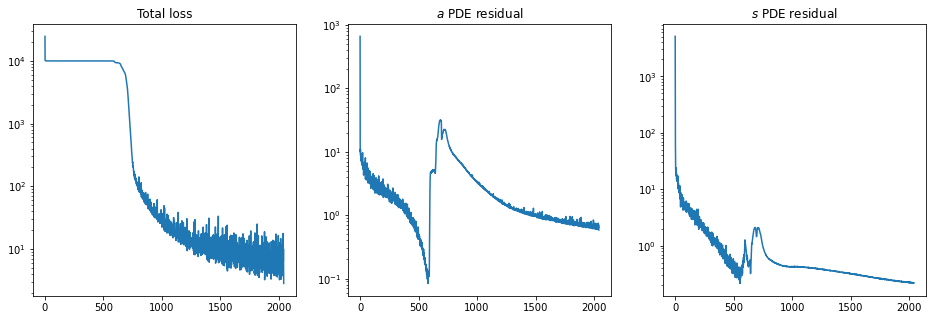

In [5]:
start = 0
end = len(loss)
_ = plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.plot(loss[start:end])
plt.yscale('log')
plt.title(r"Total loss")

plt.subplot(1,3,2)
plt.plot(loss_a[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")


plt.subplot(1,3,3)
plt.plot(loss_s[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")

plt.show()



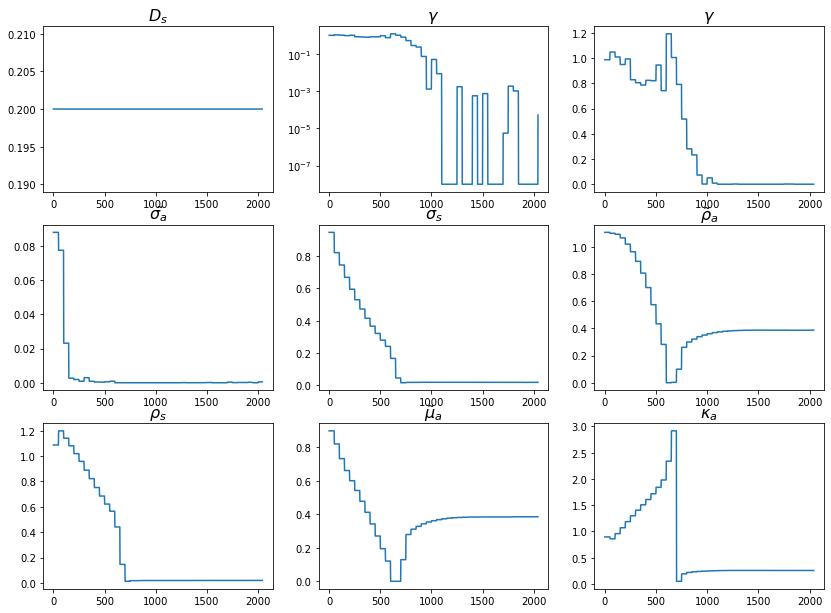

In [6]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))

plt.subplot(4,3,1)
plt.plot(np.r_[params_estimates['D_s']])
plt.title(r"$D_s$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,2)
plt.plot(np.r_[params_estimates['gamma']])
plt.title(r"$\gamma$", fontsize=16)
plt.yscale('log')

plt.subplot(4,3,3)
plt.plot(np.r_[params_estimates['gamma']])
plt.title(r"$\gamma$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,4)
plt.plot(np.r_[params_estimates['sigma_a']])
plt.title(r"$\tilde{\sigma_a}$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,5)
plt.plot(np.r_[params_estimates['sigma_s']])
plt.title(r"$\sigma_s$", fontsize=16)
#plt.yscale('log')
#plt.ylim([0.005,.04])

plt.subplot(4,3,6)
plt.plot(np.r_[params_estimates['rho_a']])
plt.title(r"$\tilde{\rho}_a$", fontsize=16)
#plt.yscale('log')


plt.subplot(4,3,7)
plt.plot(np.r_[params_estimates['rho_s']])
plt.title(r"$\rho_s$", fontsize=16)
#plt.yscale('log')
#plt.ylim([0.0,.05])


plt.subplot(4,3,8)
plt.plot(np.r_[params_estimates['mu_a']])
plt.title(r"$\tilde{\mu}_a$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,9)
plt.plot(np.r_[params_estimates['kappa_a']])
plt.title(r"$\kappa_a$", fontsize=16)
#plt.yscale('log')
#plt.ylim([0,1])


plt.show()

In [8]:
def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
    

gamma = model.sess.run(model.gamma)
D_s = model.sess.run(model.D_s)
sigma_s = model.sess.run(model.sigma_s)
rho_s = model.sess.run(model.rho_s)

sigma_a_tilde = model.sess.run(model.sigma_a_tilde)
rho_a_tilde = model.sess.run(model.rho_a_tilde)
mu_a_tilde = model.sess.run(model.mu_a_tilde)
kappa_a = model.sess.run(model.kappa_a)


print_vals("gamma", gamma, 0.2/0.005)


print_vals("D_s", D_s, 0.2)
print_vals("sigma_s", sigma_s, 0.02)
print_vals("rho_s", rho_s, 0.02)
print()
print_vals("sigma_a_tilde", sigma_a_tilde)
print_vals("rho_a_tilde", rho_a_tilde)
print_vals("mu_a_tilde", mu_a_tilde)
print()
print_vals("D_a", D_s/gamma, 0.005)
print_vals("sigma_a", sigma_a_tilde/gamma, 0.0)
print_vals("rho_a", rho_a_tilde/gamma,0.01)
print_vals("mu_a", mu_a_tilde/gamma, 0.01 )
print_vals("kappa_a", kappa_a, 0.25)
print()
print_vals("sigma_a", sigma_a_tilde/40, 0.0)
print_vals("rho_a", rho_a_tilde/40,0.01)
print_vals("mu_a", mu_a_tilde/40, 0.01 )

gamma: 0.00005215, actual: 40.000, difference: 39.99994785, relative: %99.99986963
D_s: 0.20000000, actual: 0.200, difference: 0.00000000, relative: %0.00000149
sigma_s: 0.01898721, actual: 0.020, difference: 0.00101279, relative: %5.06392904
rho_s: 0.01931274, actual: 0.020, difference: 0.00068726, relative: %3.43630314

sigma_a_tilde: 0.00050576
rho_a_tilde: 0.38649046
mu_a_tilde: 0.38460171

D_a: 3835.37524414, actual: 0.005, difference: 3835.37024414, relative: %76707404.88281250
sigma_a: 9.69882202, actual: 0.000, difference: 9.69882202 
rho_a: 7411.67968750, actual: 0.010, difference: 7411.66968750, relative: %74116696.87500000
mu_a: 7375.45947266, actual: 0.010, difference: 7375.44947266, relative: %73754494.72656250
kappa_a: 0.25534308, actual: 0.250, difference: 0.00534308, relative: %2.13723183

sigma_a: 0.00001264, actual: 0.000, difference: 0.00001264 
rho_a: 0.00966226, actual: 0.010, difference: 0.00033774, relative: %3.37738767
mu_a: 0.00961504, actual: 0.010, difference

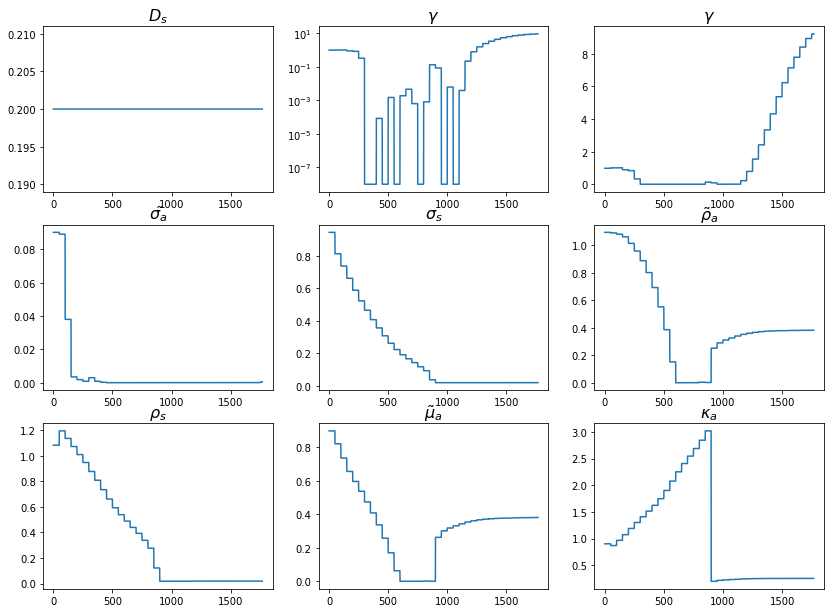

In [20]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))

plt.subplot(4,3,1)
plt.plot(np.r_[params_estimates['D_s']])
plt.title(r"$D_s$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,2)
plt.plot(np.r_[params_estimates['gamma']])
plt.title(r"$\gamma$", fontsize=16)
plt.yscale('log')

plt.subplot(4,3,3)
plt.plot(np.r_[params_estimates['gamma']])
plt.title(r"$\gamma$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,4)
plt.plot(np.r_[params_estimates['sigma_a']])
plt.title(r"$\tilde{\sigma_a}$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,5)
plt.plot(np.r_[params_estimates['sigma_s']])
plt.title(r"$\sigma_s$", fontsize=16)
#plt.yscale('log')
#plt.ylim([0.005,.04])

plt.subplot(4,3,6)
plt.plot(np.r_[params_estimates['rho_a']])
plt.title(r"$\tilde{\rho}_a$", fontsize=16)
#plt.yscale('log')


plt.subplot(4,3,7)
plt.plot(np.r_[params_estimates['rho_s']])
plt.title(r"$\rho_s$", fontsize=16)
#plt.yscale('log')
#plt.ylim([0.0,.05])


plt.subplot(4,3,8)
plt.plot(np.r_[params_estimates['mu_a']])
plt.title(r"$\tilde{\mu}_a$", fontsize=16)
#plt.yscale('log')

plt.subplot(4,3,9)
plt.plot(np.r_[params_estimates['kappa_a']])
plt.title(r"$\kappa_a$", fontsize=16)
#plt.yscale('log')
#plt.ylim([0,1])


plt.show()

# Estimated parameters 

In [21]:
def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
    

gamma = model.sess.run(model.gamma)
D_s = model.sess.run(model.D_s)
sigma_s = model.sess.run(model.sigma_s)
rho_s = model.sess.run(model.rho_s)

sigma_a_tilde = model.sess.run(model.sigma_a_tilde)
rho_a_tilde = model.sess.run(model.rho_a_tilde)
mu_a_tilde = model.sess.run(model.mu_a_tilde)
kappa_a = model.sess.run(model.kappa_a)


print_vals("gamma", gamma, 0.2/0.005)


print_vals("D_s", D_s, 0.2)
print_vals("sigma_s", sigma_s, 0.02)
print_vals("rho_s", rho_s, 0.02)
print()
print_vals("sigma_a_tilde", sigma_a_tilde)
print_vals("rho_a_tilde", rho_a_tilde)
print_vals("mu_a_tilde", mu_a_tilde)
print()
print_vals("D_a", D_s/gamma, 0.005)
print_vals("sigma_a", sigma_a_tilde/gamma, 0.0)
print_vals("rho_a", rho_a_tilde/gamma,0.01)
print_vals("mu_a", mu_a_tilde/gamma, 0.01 )

gamma: 9.22357845, actual: 40.000, difference: 30.77642155, relative: %76.94105387
D_s: 0.20000000, actual: 0.200, difference: 0.00000000, relative: %0.00000149
sigma_s: 0.01891893, actual: 0.020, difference: 0.00108107, relative: %5.40535189
rho_s: 0.01874035, actual: 0.020, difference: 0.00125965, relative: %6.29823878

sigma_a_tilde: 0.00051301
rho_a_tilde: 0.38239256
mu_a_tilde: 0.38146934

D_a: 0.02168356, actual: 0.005, difference: 0.01668356, relative: %333.67117643
sigma_a: 0.00005562, actual: 0.000, difference: 0.00005562 
rho_a: 0.04145816, actual: 0.010, difference: 0.03145816, relative: %314.58155960
mu_a: 0.04135806, actual: 0.010, difference: 0.03135806, relative: %313.58064860


In [22]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [23]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))

tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.02469804
Loss_s : 0.00683246
Loss   : 0.15395328


In [24]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

0.08457064526453287
0.03785215363282


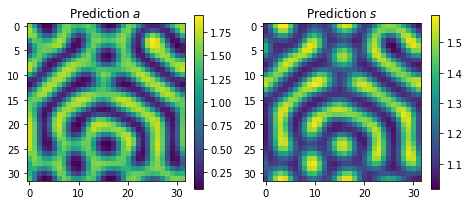

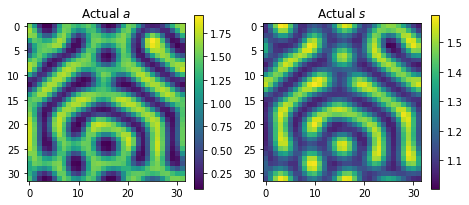

In [25]:
_ = plt.figure(figsize=(12,8))

plt.subplot(131)
plt.title(r"Prediction $a$")
plt.imshow(a_2)
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Prediction $s$")
plt.imshow(s_2)
plt.colorbar(shrink=.4)
plt.show()
_ = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title(r"Actual $a$")
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Actual $s$")
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.show()

In [26]:
graph = tf.get_default_graph()
tmp = graph.get_tensor_by_name("temp_a_t:0")
a_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_t:0")
s_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_a_diff:0")
a_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_diff:0")
s_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_kin:0")
kin = model.sess.run(tmp, tf_dict)

InvalidArgumentError: You must feed a value for placeholder tensor 'y_tf' with dtype float and shape [?,1]
	 [[node y_tf (defined at <ipython-input-3-49dcddce34f7>:67)  = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'y_tf', defined at:
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-edeb524deb67>", line 2, in <module>
    model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
  File "<ipython-input-3-49dcddce34f7>", line 67, in __init__
    self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1747, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5206, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'y_tf' with dtype float and shape [?,1]
	 [[node y_tf (defined at <ipython-input-3-49dcddce34f7>:67)  = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


gamma = 9.22, D_a = 0.021684, rho_a_tilde = 0.382393, mu_a_tilde = 0.381469339, sigma_a_tilde = 0.000513009, kappa_a = 0.2536


NameError: name 'a_t' is not defined

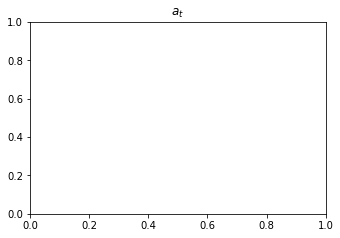

In [28]:
def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
        
gamma =  _get_val(model.sess.run(model.gamma))       
D_s = _get_val(model.sess.run(model.D_s))
sigma_s = _get_val(model.sess.run(model.sigma_s))
rho_s = _get_val(model.sess.run(model.rho_s))

D_a = D_s/gamma # _get_val(model.sess.run(model.D_a))
sigma_a_tilde = _get_val(model.sess.run(model.sigma_a_tilde))
rho_a_tilde = _get_val(model.sess.run(model.rho_a_tilde))
mu_a_tilde = _get_val(model.sess.run(model.mu_a_tilde))
kappa_a = _get_val(model.sess.run(model.kappa_a))
print(f"gamma = {gamma:.2f}, D_a = {D_a:.6f}, rho_a_tilde = {rho_a_tilde:.6f}, mu_a_tilde = {mu_a_tilde:.9f}, sigma_a_tilde = {sigma_a_tilde:.9f}, kappa_a = {kappa_a:.4f}")

# gamma*a_t - (a_xx + a_yy) - rho_a_tilde*f + mu_a_tilde*a - sigma_a_tilde
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$a_t$")
plt.imshow(a_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 2)
plt.title(r"$\gamma a_t$")
plt.imshow((gamma*a_t).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 3)
plt.title(r"$-\nabla^2 a$")
plt.imshow((-a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 4)
plt.title(r"$ \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 5)
plt.title(r"$ - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-rho_a_tilde*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 6)
plt.title(r"$- \nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-a_diff-rho_a_tilde*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 7)
plt.title(r"$-\nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a} + \tilde{\mu}_a a$")
plt.imshow((-a_diff-rho_a_tilde*kin+mu_a_tilde*a_2.flatten()[:, np.newaxis]).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 8)
plt.title(r"$- \nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a} + \tilde{\mu}_a a - \tilde{\sigma}_a$")
plt.imshow((-a_diff-rho_a_tilde*kin+mu_a_tilde*a_2.flatten()[:, np.newaxis]-sigma_a_tilde).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 9)
plt.title(r"$\gamma a_t-\nabla^2 a - \tilde{\rho}_a \frac{a^2 s}{1 + \kappa_a a} + \tilde{\mu}_a a - \tilde{\sigma}_a$")
plt.imshow((gamma*a_t-a_diff-rho_a_tilde*kin+mu_a_tilde*a_2.flatten()[:, np.newaxis]-sigma_a_tilde).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()


gamma = 0.09, D_s = 0.200000, rho_s = 0.018747, sigma_s = 0.018811, kappa_a = 0.2528


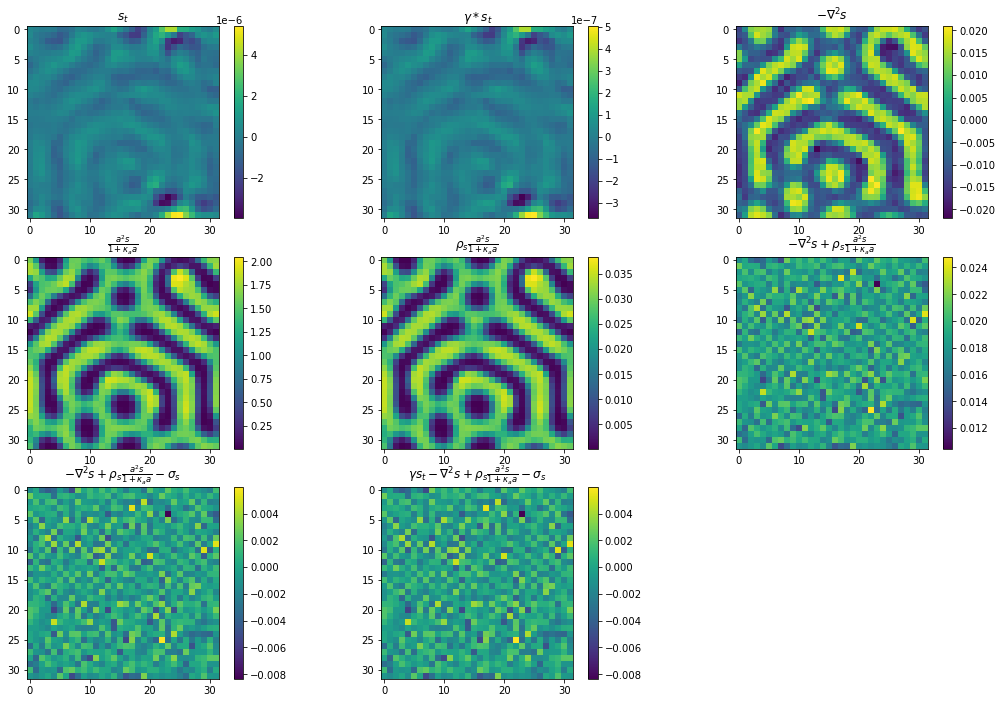

In [38]:
def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
        
gamma =  _get_val(model.sess.run(model.gamma))       
D_s = _get_val(model.sess.run(model.D_s))
sigma_s = _get_val(model.sess.run(model.sigma_s))
rho_s = _get_val(model.sess.run(model.rho_s))

D_a = _get_val(model.sess.run(model.D_a))
sigma_a_tilde = _get_val(model.sess.run(model.sigma_a_tilde))
rho_a_tilde = _get_val(model.sess.run(model.rho_a_tilde))
mu_a_tilde = _get_val(model.sess.run(model.mu_a_tilde))
kappa_a = _get_val(model.sess.run(model.kappa_a))

print(f"gamma = {gamma:.2f}, D_s = {D_s:.6f}, rho_s = {rho_s:.6f}, sigma_s = {sigma_s:.6f}, kappa_a = {kappa_a:.4f}")

# s_t - (s_xx + s_yy) + rho_s*f - sigma_s
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$s_t$")
plt.imshow(s_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 2)
plt.title(r"$\gamma*s_t$")
plt.imshow((gamma*s_t).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 3)
plt.title(r"$-\nabla^2 s$")
plt.imshow((-s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 4)
plt.title(r"$\frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)


plt.subplot(3, 3, 5)
plt.title(r"$\rho_s \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((rho_s*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 6)
plt.title(r"$-\nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-s_diff+rho_s*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)

plt.subplot(3, 3, 7)
plt.title(r"$-\nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((-s_diff+rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 8)
plt.title(r"$\gamma s_t-\nabla^2 s +  \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((gamma*s_t-s_diff+rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()